___
## <center><a id=1>Архитектуры нейронных сетей</a>

___
### <center><a id=2>VGG</a>

Архитектура:

<img src='data/vgg.webp'>

Особенности:
- При `уменьшении` разрешения `увеличивается` количество каналов

Проблемы:
- `Низкая` скорость обучения
- `Сниженная` производителность для изображений с низким разрешением

___
### <center><a id=2>ResNet</a>

Архитектура:

<img src='data/res.png' width=1200>

Особенности:
- `Residual blocks`: к выходу сблока свертки прибавляется переменная до прохождения блока, что дает устойчивость обучения и решает проблему угасания градиента
- `Bottle neck` : 
    - свертка 1х1 уменьшает кол-во `каналов`,
    - свертка 3х3 применяеся для уменьшенного кол-ва `каналов`
    - свертка 1х1 возвращает исходное кол-во `каналов`

<img src='data/resblock.png' width=600>


Плюсы:
- Решает проблему `затухания` градиентов


___
### <center><a id=3>Xception</a>

Схема сепарабельной свертки по глубине:

<img src='data/xc.png' width=600>

Особенности:

- Свертка сепарабельная по `глубине`:
    - Свертка 1х1 увеличивает кол-во каналов
    - Свертки 3х3 параллельно применяются для каждого канала отдельно
    - Все свертки 3х3 конкатенируются на выходе 

Плюсы:
- Уменьшено кол-во параметров

___
### <center><a id=3>MobilenetV2</a>

Схема блока:

<img src='data/mob.jpeg' width=800>


Особенности:

- `Инвертированный` bottle neck:

    - Свертка 1х1 перед сверткой 3х3 не уменьшает кол-во каналов, а `увеличивает`, т.к свертка по глубине уменьшает сложность

Плюсы:
- `Экономия` пиковой памяти, т.к. переменная, которая пробрасывается без прохода по блоку имеет небольшой размер 


___
### <center><a id=3>ViT</a>

Схема алгоритма:

<img src='data/vit.png' width=800>

Особенности:

- `Трансформер`, выполняющий задачи классификации лучше сверточных сетей
    - Изображение разделяется на части
    - К каждой части применяется линейная операция и прибавляется порядковый номер на исходном изображении и на ыходе получаются - эмбеддинги 
    - Каждый эмбеддинг перемножается с остальными эмбеддингами и суммируются, получая признаковое описание
    - Признаковое описание отправляется в линейные слои и softmax для классификации

___
## <center><a id=1>Обучение</a>

<img src='data/train.jpg' width=800>

**`Изменение модели`**:

- `Dropout`: 
    - уменьшает `переобучение`
    - `скорость` обучения снизится

- `Слой`: 
    - улучшение `обучаемости`
    - `скорость` обучения снизится

- `Отлавливание ошибок`: 
    - Визуализация `метрик` во время обучения
    - Анализ `худших ошибок`
    - Анализ модели на `маленьких данных`
        - Если модель не переобучениа - присутствует ошибка в модели

**`Изменение данных`**:
- `Аугментация`:
    - Увеличивает выборку
    - Добавляет устойчивость обучения

- `Псевдо-разметка`:
    1. Обучение на `размеченных данных`
    2. Предсказание на `неразмеченных данных`
    3. Выбор ответов с `большими уверенностями` модели
    4. `Добавление` к размеченным данным


___
## <center><a id=1>Дообучение модели</a>

___
<center><a>Скачивание датасета</a>

In [2]:
import wget, os


dataset_url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
data_path = 'data/hymenoptera/'

try:
    os.mkdir(data_path)
except FileExistsError:
    print('Dir already exists')
dataset_zip_path = wget.download(dataset_url, data_path)

<center><a>Распаковка датасета</a>

In [3]:
import zipfile


with zipfile.ZipFile(dataset_zip_path, 'r') as zip_f:
    zip_f.extractall(data_path)

dataset_path = os.path.splitext(dataset_zip_path)[0]

<center><a>Создание путей к файлам</a>

In [4]:
import os
from tqdm import trange

train_data = os.path.normpath(os.path.join(dataset_path, 'train'))
val_data = os.path.normpath(os.path.join(dataset_path, 'val'))

def get_filepaths(dirpath: str, class_n: int) -> list:
    """Создает список путей к файлам обучающей и валидационной выборки

    Args:
        dirpath (str): Путь к директории с данными
        class_n (int): Кол-во классов данных

    Returns:
        list: Список всех файлов обучающей / валидационной директории
    """
    result_lst = []
    for cls in trange(class_n):
        dir_class = list(os.walk(dirpath))[cls + 1][0]
        files_lst = list(os.walk(dirpath))[cls + 1][2]
        class_files = [os.path.join(dir_class, file) for file in files_lst]
        
        result_lst.extend(class_files)
    return result_lst

train_filepaths = get_filepaths(dirpath=train_data, class_n=2)
val_filepaths = get_filepaths(dirpath=val_data, class_n=2)

100%|██████████| 2/2 [00:00<00:00, 499.98it/s]


<center><a>Трансформация и Аугментация</a>

- <a>ShiftScaleRotate</a> : Случайные сдвиги/масштабирование/повороты

- <a>HorizontalFlip</a> : Горизонтальное отзеркаливание

- <a>SmallestMaxSize</a> : Приводит меньшую сторону к конкретному размеру

- <a>Normalize</a> : Нормализует изображение так, как нормализовала модель обучаясь на Imagenet

- <a>ToTensorV2</a> : Приводит изображение к тензору

In [236]:
from torchvision import transforms


RESNET_INPUT_SIZE = 224
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

train_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize(size=RESNET_INPUT_SIZE), # Приводим меньшую сторону к конкретному размеру
                transforms.CenterCrop(size=RESNET_INPUT_SIZE),
                transforms.ColorJitter(hue=(0.1,0.5)), # Смещаем цвет
                transforms.ToTensor(),# Приводим к тензору
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD), # Нормализуем изображение яркость/ констраст
])

val_trans = transforms.Compose([
            transforms.Resize(size=RESNET_INPUT_SIZE), # Приводим меньшую сторону к конкретному размеру
            transforms.CenterCrop(size=RESNET_INPUT_SIZE),
            transforms.ToTensor(),# Приводим к тензору
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


<center><a>ImageFolder + DataLoader</a>

In [252]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


train_dataset = ImageFolder(train_data, train_transform)
val_dataset = ImageFolder(val_data, val_trans)

train_dataloader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=2000)
val_dataloader = DataLoader(dataset=val_dataset, shuffle=True, batch_size=2000)

img_tensor_batch, label_batch = next(iter(train_dataloader))
print(img_tensor_batch.shape, label_batch)

torch.Size([244, 3, 224, 224]) tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0])


<center><a>Визуализация Dataset</a>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


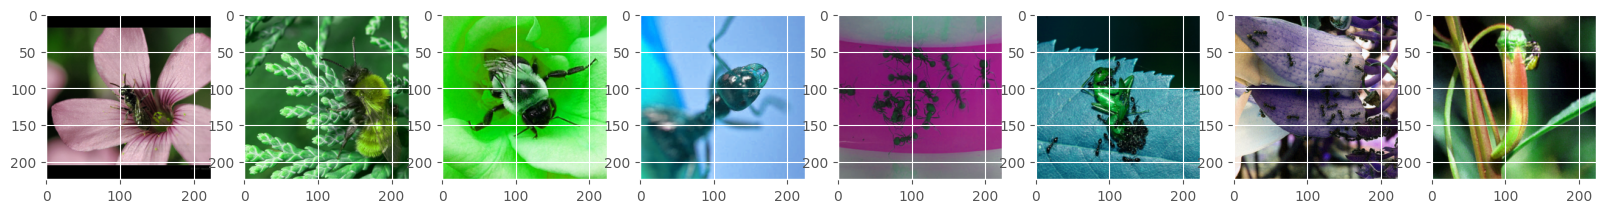

In [238]:
import matplotlib.pyplot as plt
import numpy as np

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
img_tensor_batch, y_batch = next(iter(train_dataloader))

PLOT_COUNT = 8
fig, ax = plt.subplots(1,PLOT_COUNT, figsize=(20,10))
for i in range(PLOT_COUNT):
    ax[i].imshow(img_tensor_batch[i].permute(1, 2, 0).numpy() * STD + MEAN);

___
<center><a>Импорт модели</a>

In [253]:
from torchvision import models


RESNET_INPUT_SIZE = 224
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<center><a>Изменение последнего слоя</a>

In [254]:
from torch import nn


CLASSES_N = 2
IN_FEATURES = model_ft.fc.in_features

model_ft.fc = nn.Sequential(nn.Dropout(p=0.5), 
                            nn.Linear(IN_FEATURES, CLASSES_N))

print(model_ft.fc)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=512, out_features=2, bias=True)
)


<center><a>Заморозка слоев</a>

In [261]:
for param in model_ft.parameters():
    param.requires_grad = False

model_ft.fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(IN_FEATURES, CLASSES_N))

print('Градиент отключен на всех слоях ', list(model_ft.parameters())[1],'\n')
print('Кроме созданного ',list(model_ft.fc.parameters()))

Градиент отключен на всех слоях  Parameter containing:
tensor([ 2.3487e-01,  2.6626e-01, -5.1096e-08,  5.1870e-01,  3.4404e-09,
         2.2239e-01,  4.2289e-01,  1.3153e-07,  2.5093e-01,  1.5152e-06,
         3.1687e-01,  2.5049e-01,  3.7893e-01,  1.0862e-05,  2.7526e-01,
         2.3674e-01,  2.4202e-01,  3.9531e-01,  4.6935e-01,  2.9090e-01,
         2.7268e-01,  2.7803e-01,  2.9069e-01,  2.0693e-01,  2.5899e-01,
         2.7871e-01,  2.9115e-01,  3.1601e-01,  3.8889e-01,  3.0411e-01,
         2.6776e-01,  2.1093e-01,  2.8708e-01,  3.3243e-01,  4.2673e-01,
         3.7326e-01,  7.4804e-08,  1.9068e-01,  1.4740e-08,  2.2303e-01,
         1.7908e-01,  2.4860e-01,  2.7400e-01,  2.5923e-01,  2.9420e-01,
         2.9924e-01,  2.2369e-01,  2.6280e-01,  2.2001e-08,  2.6610e-01,
         2.2089e-01,  2.8429e-01,  3.3072e-01,  2.2681e-01,  3.6538e-01,
         2.1230e-01,  2.3965e-01,  2.4950e-01,  5.2583e-01,  2.4825e-01,
         2.9565e-01,  2.5878e-01,  4.8326e-01,  2.6670e-01]) 

Кроме 

<center><a>Обучение модели</a>


In [262]:

from IPython import display
from tqdm import trange
import matplotlib.pyplot as plt
import torch


def train_model(model, device, loss, optimizer, scheduler=None, num_epochs=10, plot_n=2):
    train_loss_history, val_loss_history , train_acc_history, val_acc_history = [], [],[], []
######## Итерации по эпохам ###################################

    for epoch in trange(num_epochs):
        for phase in ['train', 'val']:
######## Устанавливает обучающий / валидационный режим ########

            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

###############################################################
            running_loss = 0.
            running_acc = 0.

######## Итерации по DataLoader ###############################

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

######## Активация градиентов, если режим train ###############

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
######## Прямой и обратный проход, если режим train ###########

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        scheduler.step()

######## Суммарные статистики по батчу ##############################

                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

######## Средние статистики по эпохам ##############################

            if phase == 'train':
                epoch_loss = running_loss / len(dataloader)
                epoch_acc = running_acc / len(dataloader)
                train_loss_history.append(epoch_loss )
                train_acc_history.append(epoch_acc.cpu() )
                
            elif phase == 'val':
                epoch_loss = running_loss / len(dataloader)
                epoch_acc = running_acc / len(dataloader)
                val_loss_history.append(epoch_loss )
                val_acc_history.append(epoch_acc.cpu() )

######## Отрисовка средних статистик по эпохам #######################

            if epoch % plot_n == 0:
                plt.style.use('ggplot')
                fig, ax = plt.subplots(1, 2, figsize=(16,7))
                display.clear_output(True)
                plt.figure(figsize=(15,7))
                ax[0].plot(train_loss_history, label='Train loss', c='r')
                ax[0].plot(val_loss_history, label='Test loss', c='b')
                ax[1].plot(train_acc_history, label='Train Acc', c='r')
                ax[1].plot(val_acc_history, label='Test Acc', c='b')

                ax[0].legend()
                ax[1].legend()
                ax[0].grid()
                ax[1].grid()
                plt.show();

                print(f'{phase} LOSS: {epoch_loss:.3f}')
                print(f'{phase} Accuracy: {epoch_acc:.3f}')
    return model

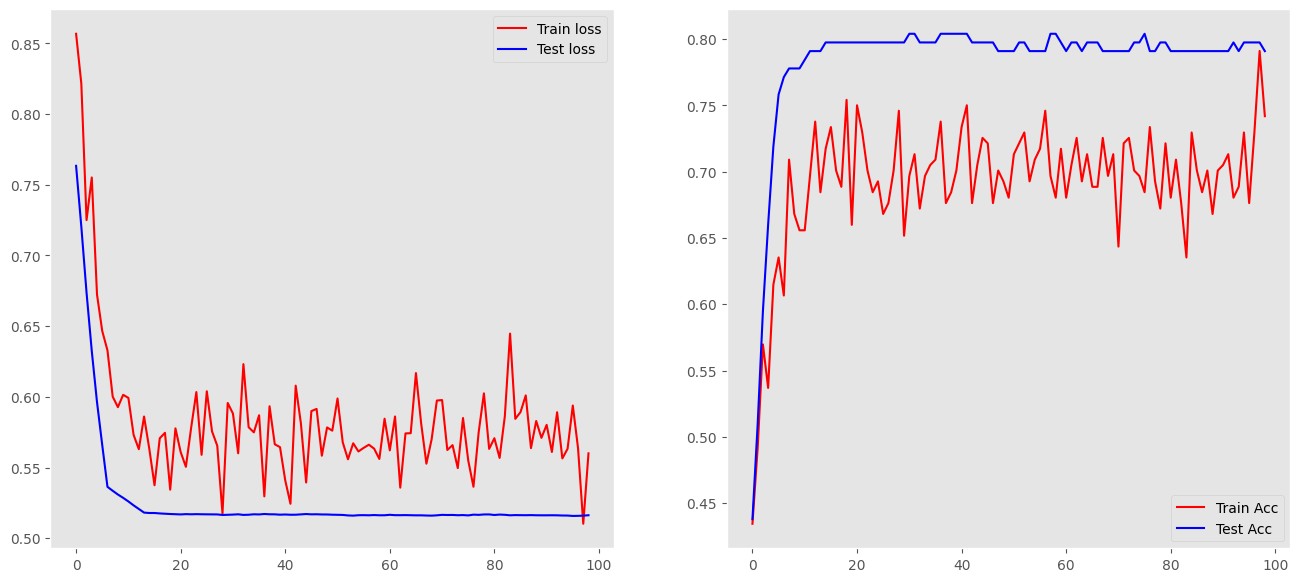

<Figure size 1500x700 with 0 Axes>

 99%|█████████▉| 99/100 [04:58<00:02,  2.99s/it]

val LOSS: 0.516
val Accuracy: 0.791


100%|██████████| 100/100 [05:01<00:00,  3.02s/it]


In [264]:
from pytorch_lightning import seed_everything
from torch import optim
import torch

seed_everything(seed=42)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model_ft.to(device)

optimizer_ft = optim.Adam( [param for param in model_ft.parameters() if param.requires_grad], lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()
scheduler_ft = optim.lr_scheduler.StepLR(optimizer=optimizer_ft, step_size=7, gamma=0.1)

trained_model = train_model(model=model_ft,
            device=device,
            loss=loss_func,
            optimizer=optimizer_ft,
            scheduler=scheduler_ft,
            num_epochs=100,
            plot_n=2)

<center><a>Оценка качества модели</a>

100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


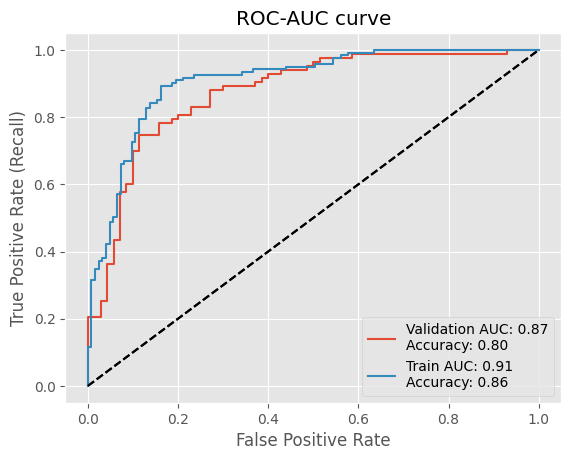

In [269]:
from  tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import Module
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score


def plt_roc_auc(trained_model: Module, dataloader: DataLoader, plotname: str):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    trained_model.to(device=device)
    trained_model.eval()
    
    test_probas = []
    test_labels = []
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)

        with torch.set_grad_enabled(False):
            preds = trained_model(inputs)

        test_probas.append(torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        test_labels.append(labels)

    test_probas = np.concatenate(test_probas)
    test_labels = np.array(test_labels).ravel()
    test_predictions = np.array([1 if proba > 0.5 else 0 for proba in test_probas  ])
    
    auc = roc_auc_score(test_labels, test_probas)
    acc = accuracy_score(test_labels, test_predictions)
    plt.plot(*roc_curve(test_labels, test_probas)[:2], label=f'{plotname} AUC: {auc:.2f}\nAccuracy: {acc:.2f}')
    plt.plot([0, 1], [0, 1], '--', color='black')
    plt.legend()
    plt.title('ROC-AUC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    return test_probas, test_labels, test_predictions

test_probas, test_labels, test_predictions = plt_roc_auc(trained_model=trained_model, dataloader=val_dataloader, plotname='Validation')
test_probas, test_labels, test_predictions = plt_roc_auc(trained_model=trained_model, dataloader=train_dataloader, plotname='Train')
    